# Reana-SPL Data Analysis

This repository contains execution data and analysis for persistent variations of the [Reana-SPL](https://github.com/SPLMC/reana-spl) tool.

# SPL Analysis Approach

Reana-SPL performs a product-line reliability analysis on a variety of software-product-lines.

To leverage the commonality among different products in order to speed up analysis,
we use a [feature-family-based analysis](https://www.infosun.fim.uni-passau.de/publications/docs/LCA+17ist.pdf). Instead of enumerating products and analyzing
them one-by-one (product-based analysis), we analyze features in isolation
and exploit the commonality among products to get results for the entire
product space more efficiently.

We analyze the data of three approaches to handling the evolved models.
- Non-evolution-aware: The analysis tool does not do any
  special handling of evolved models.
- Evolution-aware without reordering: The analysis tool handles evolved models
  by reusing ADDs generated in previous runs.
  ADDs are only automatically reordered in the first run.
- Evolution-aware with reordering: Same as the above, but ADDs are reordered
  automatically at each iteration.

We expect the non-evolution-aware analysis to perform the worst, with
both evolution-aware approaches obtaining similar results.
There is a tradeoff to ADD reordering: while it is expensive, it obtains
smaller ADDs on which operations are easier to perform.

# Data 

The data used contains runtime information for different variations of the
[Reana-SPL](https://github.com/SPLMC/reana-spl) product line analysis tool.
Different approaches are implemented in different branches of the main repository.
The main difference in the implementations is in the handling of ADD persistence.
The non-evolution-aware does not save its generated ADDs nor does it read ADDs
from previous executions, as is done in the evolution-aware implementations.

We execute an evolution scenario on the initial models of 6 different product
lines (BSN, Email, IC, Lift, MP, TW).
Each evolution doubles the amount of products to be analyzed.
Each model is evolved in a fixed manner up to 22 times, so we have an
increase in the product space of up to \(2^21\)-fold


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools as iter
from tabulate import tabulate
from scipy.stats import *

In [2]:
def out_to_csv(in_filename, out_filename):
    data = []
    i = -1
    with open(in_filename) as in_f:
        lines = in_f.readlines()
    for line in lines:
        if not isNumber(line):
            i += 1
            data.append([])
        else:
            data[i].append(float(line))
    with open(out_filename, 'w') as out_f:
        for i in range(len(data)):
            for j in range(len(data[i])):
                if j == len(data[i])-1:
                    out_f.write("{}\n".format(data[i][j]))
                else:
                    out_f.write("{},".format(data[i][j]))
        
    
def isNumber(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [3]:
def _read_data(spl, filenames, labels, factor=1.0):
    dfs = []
    for filename in filenames:
        df = pd.read_csv(filename, header=None).transpose()
        dfs.append(df)

    # delete extra rows (to match sample sizes)
    n = min([df.shape[0] for df in dfs])
    for df in dfs:
        if df.shape[0] > n:
            rows = list(range(n, df.shape[0]))
            df = df.drop(rows, inplace=True) 
        
    df = pd.concat(dfs, keys=labels)
    df *= factor
    
    return df, n

def read_data(spl, filenames, labels, factor=1.0):
    df, n = _read_data(spl, filenames, labels, factor=factor)
    df['Label'] = np.repeat(labels, np.repeat([n], len(labels)), axis=0)
    return df

In [4]:
def make_line_graph(df, spl, labels, yscale='linear', xlabel='x', ylabel='y', filename=None):

    means = []
    stds = []

    for label in labels:
        dfl = df.loc[label]
        means.append(np.mean(dfl))
        stds.append(np.std(dfl))
    
    df_mean = pd.concat(means, keys=labels)
    df_std = pd.concat(stds, keys=labels)
    
    plt.figure(figsize=(12,5)) # TODO: is this OK?
    
    axs = []

    for i in range(len(labels)):
        label = labels[i]
        if i == 0:
            ax = df_mean[label].plot(grid=True, yerr=df_std[label], label=label)
        else:
            ax = df_mean[label].plot(grid=True, secondary_y=False, yerr=df_std[label], label=label)

        axs.append(ax)

    xticks = np.arange(0, df_mean[labels[0]].shape[0], 1)

    for ax in axs:
        ax.set_xticks(xticks)
    
    # plt.legend(h1+h2, l1+l2, loc=2)
    plt.legend()
    plt.yscale(yscale)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(spl)
    if filename is not None:
        plt.savefig(filename)
        
    plt.show()

In [5]:
def make_box_plot(df, spl, title=None, xlabel='', ylabel='', filename=None):
    means = np.mean(df)
    stdevs = np.std(df)
    fig, ax_new = plt.subplots(5, 5, sharex=False, sharey=False, figsize=(20,20))
    
    # these magics work for 5 by 5 plots, which is appropriate for our current data dimensions
    i = 4
    j = 4
    while i * 5 + j + 1 > len(means):
        fig.delaxes(ax_new[i, j])
        if j == 0:
            j = 4
            i -= 1
        else:
            j -= 1

    bp = df.boxplot(by="Label",ax=ax_new.flatten()[:len(means)], figsize=(6,8))

    for i in range(len(means)):
        ax_new.flatten()[i].autoscale()
        ax_new.flatten()[i].set_xlabel(xlabel)
        ax_new.flatten()[i].set_ylabel(ylabel)
    
    if title is None:
        title = spl

    fig.suptitle(title)
    
    if filename is not None:
        plt.savefig(filename)

    plt.show()

In [6]:
def get_extended_df(spl):
    df, _ = _read_data(spl)

    reana_means = np.mean(df.loc['reana'])
    reana_std = np.std(df.loc['reana'])

    reanae_means = np.mean(df.loc['reanaE'])
    reanae_std = np.std(df.loc['reanaE'])

    reanaeord_means = np.mean(df.loc['reanaEord'])
    reanaeord_std = np.std(df.loc['reanaEord'])

    dfe = pd.DataFrame()
    dfe['means'] = pd.concat([reana_means, reanae_means], keys=['reana', 'reanaE', 'reanaEord'])
    dfe['std'] = pd.concat([reana_std, reanae_std], keys=['reana', 'reanaE', 'reanaEord'])
    return dfe

In [7]:
def is_normally_distributed(samples, significance=0.01):
    x, p = normaltest(samples)
    return p >= significance

def compare_samples(s1, s2, significance=0.01):
    if (is_normally_distributed(s1, significance=significance)
        and is_normally_distributed(s2, significance=significance)):
        # both normally distributed
        v1, p1 = bartlett(s1, s2)                                 # test variances
        equal_var= p1 >= significance
        
        v2, p2 = ttest_ind(s1, s2, equal_var=equal_var)  # equal variances is assumed unless stated otherwise
        
        method = 'T-test' if equal_var else 'Welch'      # from ttest_ind's documentation
        eq = p2 >= significance
        diff = np.mean(s1) - np.mean(s2)
        r = "Equal" if eq else 1 if diff > 0 else 2
        
        return {'result': r, 'method': method, 'p1': p1, 'v1': v1, 'p2': p2, 'v2': v2}
    else:
        # not both normally distributed
        u, p = mannwhitneyu(s1, s2, use_continuity=False)
        eq = p >= significance
        diff = np.mean(s1) - np.mean(s2)
        r = "Equal" if eq else 1 if diff > 0 else 2
        return {'result': r, 'method': 'Mann-Whitney', 'u': u, 'p2': p}

In [25]:
def test(df, t1, t2, verbose=False):
    n = get_num_evolutions(df)
    for i in range(n):
        s1 = get_evolution_samples(df, i, label=t1)
        s2 = get_evolution_samples(df, i, label=t2)
        if s1 is None or s2 is None:
            # one of the samples contains NaN
            result = None
        else:
            result = compare_samples(s1, s2)
        if verbose:
            print('{}\t{}'.format(i, result))
        else:
            if result is None:
                print('{}\tNo samples'.format(i))
            elif result['result'] == 'Equal':
                print('{}\t{} == {}'.format(i, t1, t2))
            elif result['result'] == 1:
                print('{}\t{} > {}'.format(i, t1, t2))
            elif result['result'] == 2:
                print('{}\t{} < {}'.format(i, t1, t2))

def get_num_evolutions(df):
    label = df['Label'][0]
    return df.loc[label].shape[1] - 1  # exclude type column

def get_evolution_samples(df, n, label):
    s = df.iloc[:][n].loc[label]
    if s.isnull().any():  # check if any sample is NaN
        return None
    else:
        return s

In [9]:
# This cells converts .out files to .csv

def concat(lists):
    return list(iter.chain.from_iterable(lists))

spls = ['BSN', 'Email', 'IC', 'Lift', 'MP', 'TW']
labels = ['Reana', 'ReanaE']

rt_data = concat([['running_time/totalTime{}{}'.format(spl, label) for spl in spls] for label in labels])
mem_data = concat([['memory_usage/totalMemory{}{}'.format(spl, label) for spl in spls] for label in labels])


for filename in rt_data:
    out_to_csv('data/{}.out'.format(filename), 'csv/{}.csv'.format(filename))

for filename in mem_data:
        out_to_csv('data/{}.out'.format(filename), 'csv/{}.csv'.format(filename))

In [32]:
def plot_spl(spl):
    rt_labels = ['Reana', 'ReanaE', 'ReanaEord']
    mem_labels = ['Reana', 'ReanaE']

    rt_filenames = ['csv/running_time/totalTime{}{}.csv'.format(spl, label) for label in rt_labels]
    rt_df = read_data(spl, rt_filenames, rt_labels, factor=1/1000.0) # factor converts from ms to s
    make_line_graph(rt_df, spl, rt_labels, title='{}: Running Time'.format(spl), xlabel='Evolution', ylabel='Running Time(s)', yscale='log')    
    test(rt_df, *rt_labels[0:2])
    make_box_plot(rt_df, spl, title='{}: Running Time (s)'.format(spl))

    mem_filenames = ['csv/memory_usage/totalMemory{}{}.csv'.format(spl, label) for label in mem_labels]
    mem_df = read_data(spl, mem_filenames, mem_labels)
    make_line_graph(mem_df, spl, mem_labels, title='{}: Running Time'.format(spl), xlabel='Evolution', ylabel='Memory Usage (MB)', yscale='log')  
    test(mem_df, *mem_labels)
    make_box_plot(mem_df, spl, title='{}: Memory Usage (MB)'.format(spl))

In [174]:
spl = 'Email'
rt_labels = ['Reana', 'ReanaE']
rt_filenames = ['csv/running_time/totalTime{}{}.csv'.format(spl, label) for label in rt_labels]
rt_df = read_data(spl, rt_filenames, rt_labels, factor=1/1000.0)

rt_df

0      1      2      3      4      5      6      7      8  \
Reana  0   1.140  0.405  0.445  0.566  0.418  0.444  0.459  0.447  0.535   
       1   0.389  0.394  0.729  0.646  0.423  0.458  0.440  0.619  0.464   
       2   0.386  0.395  0.598  0.403  0.481  0.440  0.431  0.461  0.473   
       3   0.393  0.409  0.633  0.447  0.409  0.423  0.440  0.435  0.460   
       4   0.387  0.401  0.633  0.402  0.422  0.446  0.430  0.474  0.510   
       5   0.394  0.394  0.584  0.401  0.442  0.433  0.443  0.448  0.480   
       6   0.387  0.401  0.401  0.660  0.432  0.410  0.483  0.459  0.495   
       7   0.390  0.419  0.395  0.406  0.419  0.686  0.444  0.451  0.461   
       8   0.382  0.390  0.590  0.430  0.409  0.455  0.439  0.444  0.491   
       9   0.384  0.392  0.402  0.409  0.414  0.442  0.444  0.457  0.476   
       10  0.388  0.403  0.400  0.417  0.420  0.446  0.428  0.436  0.471   
ReanaE 0   0.431  0.362  0.349  0.354  0.355  0.373  0.400  0.439  0.457   
       1   1.233  0.415  0.360  0.384  0.369  0.370  0.377  0.509  0.461   
       2   0.655  0.403  0.431  0.404  0.377  0.458  0.421  0.441  0.411   
       3   0.656  0.463  0.457  0.374  0.376  0.385  0.417  0.388  0.469   
       4   0.503  0.348  0.369  0.362  0.377  0.356  0.380  0.401  0.426   
       5   0.384  0.366  0.425  0.349  0.372  0.361  0.373  0.455  0.395   
       6   0.394  0.388  0.361  0.350  0.362  0.371  0.368  0.386  0.448   
       7   0.383  0.355  0.345  0.366  0.362  0.357  0.367  0.416  0.405   
       8   0.390  0.350  0.363  0.369  0.350  0.356  0.399  0.375  0.444   
       9   0.392  0.366  0.363  0.347  0.557  0.357  0.366  0.387  0.421   
       10  0.385  0.347  0.347  0.346  0.360  0.369  0.364  0.418  0.466   

               9  ...     12     13     14      15      16      17       18  \
Reana  0   0.550  ...  2.295  4.305  8.368  17.320  34.541  71.773  145.972   
       1   0.553  ...  2.347  4.430  8.739  17.491  34.832  70.686  145.260   
       2   0.548  ...  2.346  4.415  8.745  17.502  35.490  70.751  144.965   
       3   0.518  ...  2.331  4.647  8.615  17.441  34.997  70.402  145.072   
       4   0.503  ...  2.369  4.464  8.683  17.491  34.655  70.927  147.860   
       5   0.554  ...  2.309  4.552  8.665  17.217  35.024  70.723  144.847   
       6   0.500  ...  2.597  4.298  8.888  17.355  34.887  70.916  147.090   
       7   0.525  ...  2.294  4.438  8.849  17.648  35.308  70.546  146.893   
       8   0.554  ...  2.315  4.613  8.605  17.434  35.170  70.648  145.038   
       9   0.502  ...  2.319  4.577  8.795  17.334  35.112  70.442  145.641   
       10  0.718  ...  2.283  4.639  8.653  17.627  34.629  70.804  145.150   
ReanaE 0   0.438  ...  0.978  1.684  3.158   6.436  12.777  26.753   54.756   
       1   0.559  ...  1.037  1.700  3.146   6.335  12.774  26.016   53.667   
       2   0.440  ...  0.993  1.700  3.242   6.403  12.776  26.640   55.134   
       3   0.440  ...  1.032  1.691  3.175   6.396  12.847  26.419   53.808   
       4   0.482  ...  1.028  1.713  3.140   6.611  12.746  26.398   54.246   
       5   0.434  ...  1.003  1.703  3.170   6.400  12.738  26.561   54.131   
       6   0.511  ...  0.998  1.700  3.211   6.398  12.949  26.375   53.217   
       7   0.438  ...  1.021  1.725  3.134   6.361  12.817  26.539   53.889   
       8   0.450  ...  0.971  1.702  3.168   6.374  12.780  26.506   53.766   
       9   0.440  ...  1.024  1.714  3.166   6.448  12.746  26.274   54.114   
       10  0.465  ...  0.966  1.683  3.175   6.374  12.766  26.588   53.968   

                19       20   Label  
Reana  0   303.683      NaN   Reana  
       1   299.426      NaN   Reana  
       2   296.722      NaN   Reana  
       3   299.162      NaN   Reana  
       4   305.680      NaN   Reana  
       5   299.308      NaN   Reana  
       6   307.457      NaN   Reana  
       7   304.466      NaN   Reana  
       8   297.358      NaN   Reana  
       9   299.647      NaN   Reana  
       10  300.892      NaN   

In [175]:
# get_evolution_samples(rt_df, 20, 'Reana')
rt_df.iloc[:][20].loc['Reana'].isnull().any()

True

In [176]:
n = 19
s1 = get_evolution_samples(rt_df, n, 'Reana')
s2 = get_evolution_samples(rt_df, n, 'ReanaE')

print('{}+-{}'.format(np.mean(s1), np.std(s1)))
print('{}+-{}'.format(np.mean(s2), np.std(s2)))

301.25463636363634+-3.3604648291223946
111.61336363636362+-0.7954487895895644


In [177]:
d = compare_samples(s1, s2)
d

/home/breno/.local/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


{'result': 1,
 'method': 'Welch',
 'p1': 9.260105232450506e-05,
 'v1': 15.281869593319183,
 'p2': 1.9214978383464076e-20,
 'v2': 173.6581791927959}

In [178]:
spls = ['BSN', 'Email', 'IC', 'Lift', 'MP', 'TW']

In [33]:
plot_spl('Email')

TypeError: make_line_graph() got an unexpected keyword argument 'title'

In [ ]:
plot_spl('BSN')

In [ ]:
plot_spl('IC')

In [ ]:
plot_spl('Lift')

In [ ]:
plot_spl('MP')

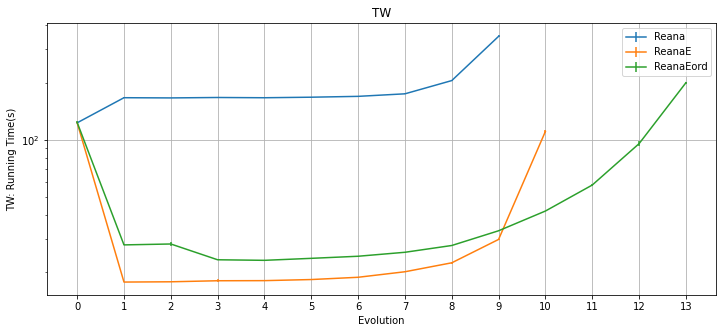

0	Reana == ReanaE
1	Reana > ReanaE
2	Reana > ReanaE
3	Reana > ReanaE
4	Reana > ReanaE
5	Reana > ReanaE
6	Reana > ReanaE
7	Reana > ReanaE
8	Reana > ReanaE
9	Reana > ReanaE
10	No samples
11	No samples
12	No samples
13	No samples


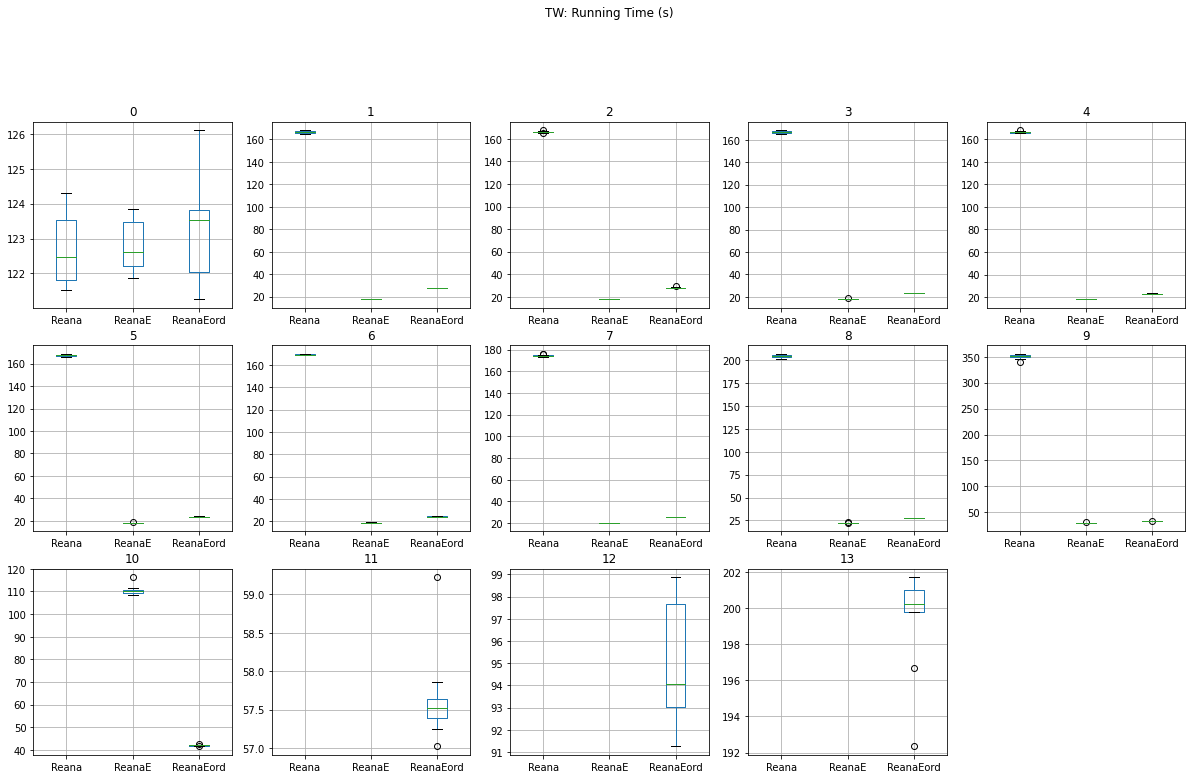

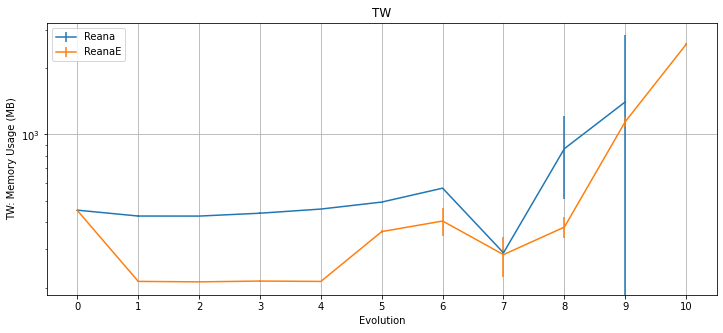

0	Reana == ReanaE
1	Reana > ReanaE
2	Reana > ReanaE
3	Reana > ReanaE
4	Reana > ReanaE
5	Reana > ReanaE
6	Reana > ReanaE
7	Reana == ReanaE
8	Reana > ReanaE
9	Reana > ReanaE
10	No samples


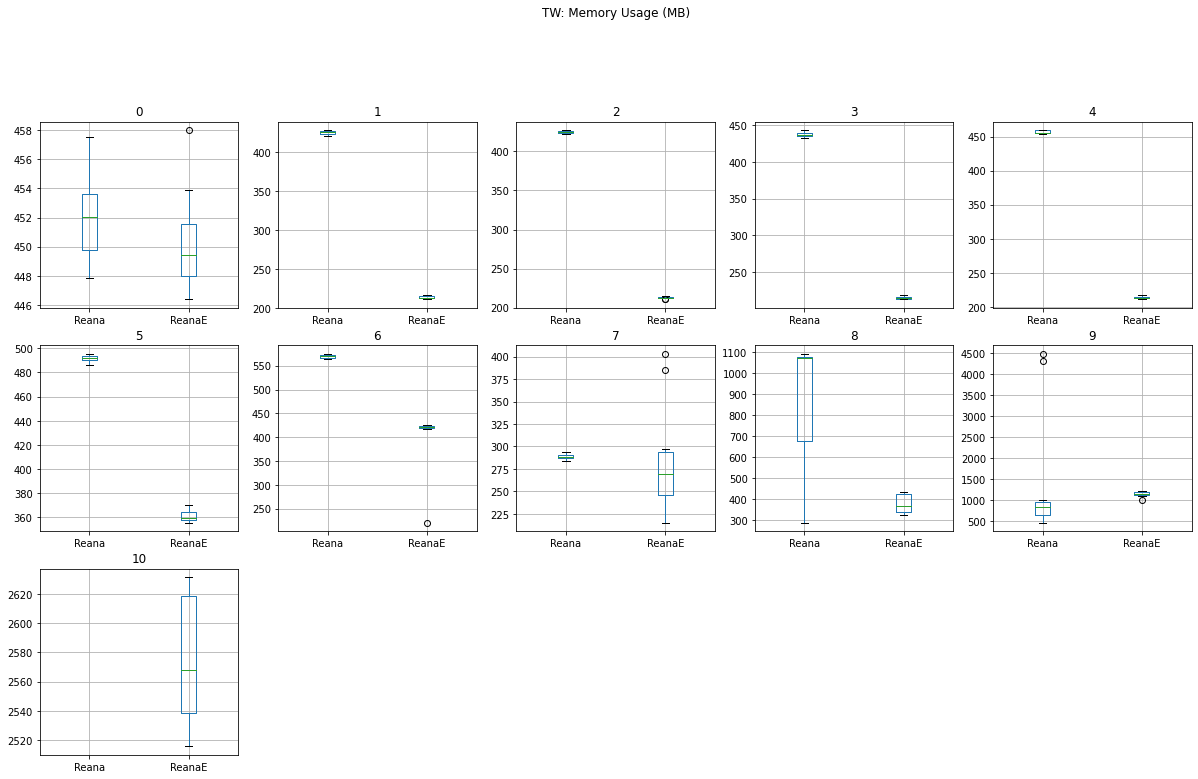

In [31]:
plot_spl('TW')